# CSE527 Homework 4
**Due date: 23:59 on Nov. 5, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.



In [0]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Set your working directory (in your google drive)
# Note that 'gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/hw4' is just an example, 
#   change it to your specific homework directory.
cd '/content/gdrive/My Drive/Kurakula_Mohith_112504214_HW4'

/content/gdrive/My Drive/CSE527_HW4_Fall19


In [0]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
  #
  # Write your code here
  norm_img= 2 * (np.float32(img) / 255 - 0.5)     # normalize img pixels to [-1, 1]
  #
  return norm_img
  
def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                rotate_90=False, zero_centered=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
            
    #
    # Write your Data Augmentation code here
    # mirroring
    #
    if augment:
      augment_data= [np.flip(img, 1) for img in data]
      data.extend(augment_data)
      labels.extend(labels)

      
            
    #
    # Write your Data Normalization code here
    # norm data to zero-centered
    #
     
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'OpenCountry', 1: 'Street', 2: 'Office', 3: 'Suburb', 4: 'InsideCity', 5: 'Kitchen', 6: 'Store', 7: 'LivingRoom', 8: 'TallBuilding', 9: 'Mountain', 10: 'Coast', 11: 'Forest', 12: 'Highway', 13: 'Flower', 14: 'Bedroom', 15: 'Industrial', 16: '_DS_Store'} 


In [0]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
4800
50
Finish loading 96 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class:

Kitchen


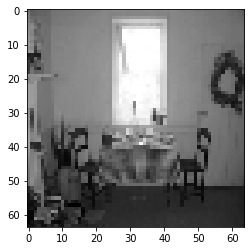

In [0]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

# 1a)

  **Data Augmentation**: We use mirroring of the image here. we increase the number of training images by using np.flip to flip each image horizontally.

**Data Normolization**  : The pixels are normalized to [-1,1],we get this by dividing each pixel by 255, subracting mean(0.5) and multiplying by 2. we can get this from the (show images unnormalize)

**Network Architecture**: 

*   Convolution Layer : (input=1 ,output = 8, Kernel size=(6 X 6), stride=1)
*   Rectified Linear Unit 
* Maxpool : (Kernel size= 6 ,stride = 6 ,padding =0 , dilation = 1 ,ceil_mode= False)
* Dropout : (p=0.5)
* Fully Linear Connected : (in_features=648,out_features = 16 ,bias = True)

**Accuracy,Training and Testing Time**

Total Training time:136.71501

The accuracy of my Model is : 58%

Total Testing Time: 0.093445

And as we can see that as the epoch increases the loss decreases.




In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================

class Neural_arch(nn.Module):
    def __init__(self):
      super(Neural_arch, self).__init__()
      self.convloution = nn.Conv2d(1, 8, 6)
      self.relu = nn.ReLU() 
      self.maxpool   = nn.MaxPool2d(6,6)                 
      self.dropout   = nn.Dropout2d(p=0.5)
      self.fullyconnected = nn.Linear(648,16)
    def forward(self,x):
      x= self.convloution(x)
      x= self.relu(x)
      x= self.maxpool(x)
      x = x.view(-1, self.features(x))
      x= self.dropout(x)
      x= self.fullyconnected(x)
      return x
    def features(self ,x):
      size=x.size()[1:]
      features = 1
      for i in size:
        features= features*i
      return features

net= Neural_arch()
print(net)


Neural_arch(
  (convloution): Conv2d(1, 8, kernel_size=(6, 6), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fullyconnected): Linear(in_features=648, out_features=16, bias=True)
)


In [0]:
# ==========================================
#         Optimize/Train Network
# ==========================================
import torch.optim as optim

cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)
def train_model(net,cross_entropy_loss,optimizer,epoch,trainloader_small):
  train_start= time.time()
  for epoch in range(epoch):
    loss=0
    for i, data in enumerate(trainloader_small,0):
      inps ,labels= data
      inps , labels = Variable(inps), Variable(labels)
      optimizer.zero_grad()
      net.train(True)
      outs=net(inps)
      cross_loss = cross_entropy_loss(outs,labels)
      cross_loss.backward()
      optimizer.step()
      loss  = loss+ cross_loss.data
    print('Epoch:{} loss {:.2f}'.format(epoch+1,loss/60))
  train_end=time.time()  
  return train_end-train_start

  
time_1=train_model(net,cross_entropy_loss,optimizer,45,trainloader_small)
print("Total Training time:{:.5f}".format(time_1))







Epoch:1 loss 4.18
Epoch:2 loss 3.48
Epoch:3 loss 3.11
Epoch:4 loss 2.87
Epoch:5 loss 2.78
Epoch:6 loss 2.68
Epoch:7 loss 2.61
Epoch:8 loss 2.57
Epoch:9 loss 2.53
Epoch:10 loss 2.49
Epoch:11 loss 2.48
Epoch:12 loss 2.44
Epoch:13 loss 2.38
Epoch:14 loss 2.34
Epoch:15 loss 2.31
Epoch:16 loss 2.31
Epoch:17 loss 2.24
Epoch:18 loss 2.24
Epoch:19 loss 2.21
Epoch:20 loss 2.23
Epoch:21 loss 2.17
Epoch:22 loss 2.13
Epoch:23 loss 2.12
Epoch:24 loss 2.12
Epoch:25 loss 2.12
Epoch:26 loss 2.09
Epoch:27 loss 2.06
Epoch:28 loss 2.05
Epoch:29 loss 2.07
Epoch:30 loss 2.05
Epoch:31 loss 2.04
Epoch:32 loss 2.02
Epoch:33 loss 2.01
Epoch:34 loss 2.00
Epoch:35 loss 2.01
Epoch:36 loss 1.98
Epoch:37 loss 1.96
Epoch:38 loss 1.96
Epoch:39 loss 1.93
Epoch:40 loss 1.98
Epoch:41 loss 1.95
Epoch:42 loss 1.94
Epoch:43 loss 1.93
Epoch:44 loss 1.90
Epoch:45 loss 1.92
Total Training time:181.95807


In [0]:
# ==========================================
#            Evaluating Network
# ==========================================
def test_model(net,testloader_small):
  test_start = time.clock()
  running_corrects = 0
  total = 0
  test_start=time.time()
  for data in testloader_small:
    imgs , labels = data
    net.train(False)
    outs=net(Variable(imgs))
    _,prediction=torch.max(outs.data,1)
    total=total+labels.size(0)
    running_corrects=running_corrects+(prediction == labels).sum()
  test_end=time.time()
  return running_corrects,total, test_end-test_start
  
running_corrects,total,test_time=test_model(net,testloader_small)
print("The accuracy of my Model is : {}%".format(100*running_corrects/total))
print("Total Testing Time: {:.6f}".format(test_time))


The accuracy of my Model is : 58%
Total Testing Time: 0.102821


# 1b) 
**1.**  For the first one I added the BatchNorm2d and the results are as follows.

**Accuracy,Training and Testing Time:**

Total Training time:283.64072

The accuracy of my Model is : 57%

Total Testing Time: 0.127989

The accuracy is almost same as that of the one for 1)a

**2.**  For the second one i used the tanh activation and the results are as follows

**Accuracy,Training and Testing Time:**

Total Training time:208.70347

The accuracy of my Model is : 60%

Total Testing Time: 0.118239

The accuracy we got from this one is greater than that of all others.It gives the highest accuracy

**3.** For the tird one i used the sigmoid activation and the results are as follows:

**Accuracy,Training and Testing Time:**

Total Training time:220.62138

The accuracy of my Model is : 46%

Total Testing Time: 0.112651

By using this sigmoid activation i got the least accuracy out of all the others.


In [0]:
class Model1(nn.Module):
    def __init__(self):
      super(Model1, self).__init__()
      self.convloution = nn.Conv2d(1, 8, 6)
      self.batch= nn.BatchNorm2d(8)
      self.relu = nn.ReLU() 
      self.maxpool   = nn.MaxPool2d(6,6)                 
      self.dropout   = nn.Dropout2d(p=0.5)
      self.fullyconnected = nn.Linear(648,16)
    def forward(self,x):
      x= self.convloution(x)
      x = self.batch(x)
      x= self.relu(x)
      x= self.maxpool(x)
      x = x.view(-1, self.features(x))
      x= self.dropout(x)
      x= self.fullyconnected(x)
      return x
    def features(self ,x):
      size=x.size()[1:]
      features = 1
      for i in size:
        features= features*i
      return features

model1= Model1()
print(model1)
cross_entropy_loss1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr = 0.001)

time_1=train_model(model1,cross_entropy_loss1,optimizer1,45,trainloader_small)
print("Total Training time:{:.5f}".format(time_1))

running_corrects,total,test_time=test_model(model1,testloader_small)
print("The accuracy of my Model is : {}%".format(100*running_corrects/total))
print("Total Testing Time: {:.6f}".format(test_time))

Model1(
  (convloution): Conv2d(1, 8, kernel_size=(6, 6), stride=(1, 1))
  (batch): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fullyconnected): Linear(in_features=648, out_features=16, bias=True)
)
Epoch:1 loss 4.37
Epoch:2 loss 3.83
Epoch:3 loss 3.49
Epoch:4 loss 3.24
Epoch:5 loss 3.02
Epoch:6 loss 2.81
Epoch:7 loss 2.62
Epoch:8 loss 2.58
Epoch:9 loss 2.43
Epoch:10 loss 2.39
Epoch:11 loss 2.37
Epoch:12 loss 2.26
Epoch:13 loss 2.26
Epoch:14 loss 2.25
Epoch:15 loss 2.23
Epoch:16 loss 2.18
Epoch:17 loss 2.16
Epoch:18 loss 2.15
Epoch:19 loss 2.12
Epoch:20 loss 2.12
Epoch:21 loss 2.12
Epoch:22 loss 2.07
Epoch:23 loss 2.07
Epoch:24 loss 2.07
Epoch:25 loss 2.08
Epoch:26 loss 2.05
Epoch:27 loss 2.04
Epoch:28 loss 2.04
Epoch:29 loss 2.05
Epoch:30 loss 2.00
Epoch:31 loss 2.01
Epoch:32 loss 1.99
Epoch:33 loss 

In [0]:
class Model2(nn.Module):
    def __init__(self):
      super(Model2, self).__init__()
      self.convloution = nn.Conv2d(1, 8, 6)
      self.tanh = nn.Tanh() 
      self.maxpool   = nn.MaxPool2d(6,6)                 
      self.dropout   = nn.Dropout2d(p=0.5)
      self.fullyconnected = nn.Linear(648,16)
    def forward(self,x):
      x= self.convloution(x)
      x= self.tanh(x)
      x= self.maxpool(x)
      x = x.view(-1, self.features(x))
      x= self.dropout(x)
      x= self.fullyconnected(x)
      return x
    def features(self ,x):
      size=x.size()[1:]
      features = 1
      for i in size:
        features= features*i
      return features

model2= Model2()
print(model2)
cross_entropy_loss2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr = 0.001)

time_1=train_model(model2,cross_entropy_loss2,optimizer2,45,trainloader_small)
print("Total Training time:{:.5f}".format(time_1))

running_corrects,total,test_time=test_model(model2,testloader_small)
print("The accuracy of my Model is : {}%".format(100*running_corrects/total))
print("Total Testing Time: {:.6f}".format(test_time))

Model2(
  (convloution): Conv2d(1, 8, kernel_size=(6, 6), stride=(1, 1))
  (tanh): Tanh()
  (maxpool): MaxPool2d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fullyconnected): Linear(in_features=648, out_features=16, bias=True)
)
Epoch:1 loss 3.98
Epoch:2 loss 3.39
Epoch:3 loss 3.11
Epoch:4 loss 2.93
Epoch:5 loss 2.78
Epoch:6 loss 2.65
Epoch:7 loss 2.50
Epoch:8 loss 2.40
Epoch:9 loss 2.31
Epoch:10 loss 2.24
Epoch:11 loss 2.16
Epoch:12 loss 2.09
Epoch:13 loss 2.06
Epoch:14 loss 2.00
Epoch:15 loss 1.98
Epoch:16 loss 1.93
Epoch:17 loss 1.91
Epoch:18 loss 1.87
Epoch:19 loss 1.88
Epoch:20 loss 1.81
Epoch:21 loss 1.80
Epoch:22 loss 1.82
Epoch:23 loss 1.77
Epoch:24 loss 1.78
Epoch:25 loss 1.75
Epoch:26 loss 1.74
Epoch:27 loss 1.73
Epoch:28 loss 1.71
Epoch:29 loss 1.69
Epoch:30 loss 1.67
Epoch:31 loss 1.69
Epoch:32 loss 1.66
Epoch:33 loss 1.65
Epoch:34 loss 1.66
Epoch:35 loss 1.62
Epoch:36 loss 1.65
Epoch:37 loss 1.62
Epoch:38 

In [0]:
class Model3(nn.Module):
    def __init__(self):
      super(Model3, self).__init__()
      self.convloution = nn.Conv2d(1, 8, 6)
      self.sigmoid = nn.Sigmoid() 
      self.maxpool   = nn.MaxPool2d(6,6)                 
      self.dropout   = nn.Dropout2d(p=0.5)
      self.fullyconnected = nn.Linear(648,16)
    def forward(self,x):
      x= self.convloution(x)
      x= self.sigmoid(x)
      x= self.maxpool(x)
      x = x.view(-1, self.features(x))
      x= self.dropout(x)
      x= self.fullyconnected(x)
      return x
    def features(self ,x):
      size=x.size()[1:]
      features = 1
      for i in size:
        features= features*i
      return features

model3= Model3()
print(model3)
cross_entropy_loss3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr = 0.001)

time_1=train_model(model3,cross_entropy_loss3,optimizer3,45,trainloader_small)
print("Total Training time:{:.5f}".format(time_1))

running_corrects,total,test_time=test_model(model3,testloader_small)
print("The accuracy of my Model is : {}%".format(100*running_corrects/total))
print("Total Testing Time: {:.6f}".format(test_time))

Model3(
  (convloution): Conv2d(1, 8, kernel_size=(6, 6), stride=(1, 1))
  (sigmoid): Sigmoid()
  (maxpool): MaxPool2d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fullyconnected): Linear(in_features=648, out_features=16, bias=True)
)
Epoch:1 loss 4.47
Epoch:2 loss 4.24
Epoch:3 loss 4.11
Epoch:4 loss 4.06
Epoch:5 loss 4.01
Epoch:6 loss 3.98
Epoch:7 loss 3.96
Epoch:8 loss 3.92
Epoch:9 loss 3.92
Epoch:10 loss 3.89
Epoch:11 loss 3.84
Epoch:12 loss 3.83
Epoch:13 loss 3.75
Epoch:14 loss 3.72
Epoch:15 loss 3.64
Epoch:16 loss 3.58
Epoch:17 loss 3.50
Epoch:18 loss 3.44
Epoch:19 loss 3.37
Epoch:20 loss 3.29
Epoch:21 loss 3.27
Epoch:22 loss 3.20
Epoch:23 loss 3.16
Epoch:24 loss 3.11
Epoch:25 loss 3.08
Epoch:26 loss 3.07
Epoch:27 loss 3.01
Epoch:28 loss 3.01
Epoch:29 loss 2.99
Epoch:30 loss 2.97
Epoch:31 loss 2.93
Epoch:32 loss 2.90
Epoch:33 loss 2.91
Epoch:34 loss 2.90
Epoch:35 loss 2.87
Epoch:36 loss 2.84
Epoch:37 loss 2.82
Epo

## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [0]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
2400
50
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class:

In [0]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)
alexnet1= models.alexnet(pretrained=True)

In [0]:
print (alexnet)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#  Part 2 ----- Strategy A :

**Layer Replace**: We remove the last layer from the alexnet pretrained model because we use it to learn only the features.

**Architecture** As given in the question histograms are generated for the first 200 activations and we get the train and test hists and these are sent for training and testing svm model.

**Accuracy and Time taken:**

The accuracy of my Model is : 69.25%

Total Training Time: 0.238635

Total Testing Time: 0.005422



In [0]:
print("after deleting last layer")
del alexnet1.classifier[-1]
print(alexnet1.classifier)

after deleting last layer
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
)


In [0]:
from sklearn import svm
from sklearn.svm import LinearSVC

def histogram(img):
  image=img[:200]
  t_sum=torch.sum(image)
  norm=[i/t_sum for i in image]
  histogram = [i.item() for i in norm]
  #print(histogram)
  return histogram

labels_train=[]
labels_test=[]
hist_train=[]
hist_test=[]
#k=0
for data in trainloader_large:
  #k=k+1
  #print(k)
  imgs , labels = data
  imgs ,labels = Variable(imgs), Variable(labels)
  outs=alexnet1(imgs)
  labels_train.append(labels)
  for i in outs:
    hist_train.append(histogram(i))

#k=0
#print(labels_train)
# We use the same code which we used in the above for getting labels and using 2 loops to get the ind labels for the svm
labels_svm_train=[]
for i in labels_train:
  for j in i:
    labels_svm_train.append(j)
#print(labels_svm_train)
for data in testloader_large:
  #k=k+1
  #print(k)
  imgs , labels = data
  imgs ,labels = Variable(imgs), Variable(labels)
  outs=alexnet1(imgs)
  labels_test.append(labels)
  for i in outs:
    hist_test.append(histogram(i))
labels_svm_test=[]
for i in labels_test:
  for j in i:
    labels_svm_test.append(j)


In [0]:
svm=LinearSVC(tol = 0.0000000001, max_iter = 100000)
train_start = time.time()
svm.fit(hist_train,labels_svm_train)
train_end = time.time()

test_start=time.time()
prediction=svm.predict(hist_test)
test_end=time.time()

train_time = train_end-train_start
test_time =  test_end -test_start
accuracy = (np.sum(prediction == labels_svm_test)) / float(len(labels_svm_test))

print("The accuracy of my Model is : {}%".format(accuracy*100))
print("Total Training Time: {:.6f}".format(train_time))
print("Total Testing Time: {:.6f}".format(test_time))


The accuracy of my Model is : 69.25%
Total Training Time: 0.238635
Total Testing Time: 0.005422


#  Part1--------Strategy B  : 

**Replace Layer** : The last layer in alexnet classifier is replaced with the outputs = 16 as we have only 16 with the previous predefined 1000.

Before:

(classifier): Sequential(
   *  (0): Dropout(p=0.5, inplace=False)
   * (1): Linear(in_features=9216, out_features=4096, bias=True)
   *  (2): ReLU(inplace=True)
   * (3): Dropout(p=0.5, inplace=False)
   * (4): Linear(in_features=4096, out_features=4096, bias=True)
   * (5): ReLU(inplace=True)
   * (6): Linear(in_features=4096, out_features=1000, bias=True)


  After Modifying:

  (classifier): Sequential(
   *  (0): Dropout(p=0.5, inplace=False)
   * (1): Linear(in_features=9216, out_features=4096, bias=True)
   *  (2): ReLU(inplace=True)
   * (3): Dropout(p=0.5, inplace=False)
   * (4): Linear(in_features=4096, out_features=4096, bias=True)
   * (5): ReLU(inplace=True)
   * (6): Linear(in_features=4096, out_features=16, bias=True)

**Architecture** : After replacing the last layer of the pretrained alexnet we use this replaced one for training and testing we use the sgd optimizer

**Accuracy and Time Taken:**

The accuracy of my Model is : 85%

Total Training Time: 3898.3439407348633

Total Testing Time: 10.751912832260132






In [0]:
net=list(alexnet.classifier)
net[6]=nn.Linear(4096,16)
net=nn.Sequential(*net)
print("after Modifying")
alexnet.classifier= net
print(alexnet)

cross_entro_loss = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)
time_1=train_model(alexnet,cross_entro_loss,sgd_optimizer,20,trainloader_large)

print("Total Training Time: {}".format(time_1))


after Modifying
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=40

In [0]:
running_corrects,total,test_time=test_model(alexnet,testloader_large)
print("The accuracy of my Model is : {}%".format(100*running_corrects/total))
print("Total Testing Time: {}".format(test_time))



The accuracy of my Model is : 85%
Total Testing Time: 10.751912832260132


<!--Write your report here in markdown or html-->
